In [2]:
# Support Vector Machine example

# The aim is to understand what support vectors are and how a SVM could classify examples
# when it seems that there is no obvious linear separability between them.

# Import the necessary libs
# and set the backend for matplotlib to include graphs in the notebook directly
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

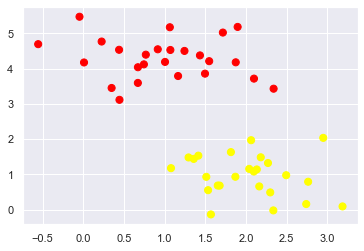

In [6]:
# Let's consider a classification task
# Just create some random data that can be easily separated into two classes

from sklearn.datasets.samples_generator import make_blobs

X, y = make_blobs(n_samples=50, centers=2, random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

(-1.0, 3.5)

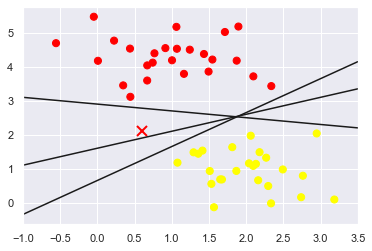

In [12]:
# A linear classifier could separate the data via a straight line.
# However, there are many lines that can separate the data.
# Depending on which you choose, a new data point "X", will be assigned a different label.
# Let's see..

xfit = np.linspace(-1, 3.5)

# Same line as above to redraw the points
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

# Draw a point and mark it as an "x"
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10) 

# Plot 3 lines that separate the data
for m,b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m*xfit+b, '-k')
plt.xlim(-1, 3.5)

(-1.0, 3.5)

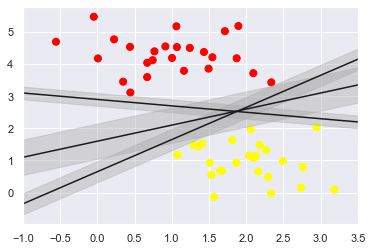

In [13]:
# How SVM works.

# Rather than simply draw a line to separate the data, we can draw around each line a margin
# of some width, up to the nearest point.

# Just use the same code as above to redraw the data points and the lines
# but now include a margin around each line
xfit = np.linspace(-1, 3.5)

# Same line as above to redraw the points
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

# Plot 3 lines that separate the data
for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m*xfit+b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit-d, yfit+d, edgecolor='none', color='#AAAAAA', alpha=0.4)
plt.xlim(-1, 3.5)

In [14]:
# In SVMs, the line that maximizes the margin is the one that we choose as the optimal model.
# SVMs are an example of Maximum Margin Estimators

In [15]:
# Let's fit an SVM to these data
from sklearn.svm import SVC # support vector classifier
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

In [42]:
# Let's visualize what happened here.

# We will need a function that will plot the decision boundaries

def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot decision function for 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # Create grid
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # Plot decision boundary and margins
    ax.contour(X, Y, P, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
    # Plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                  model.support_vectors_[:, 1],
                  s=300, linewidth=1, facecolors='none', edgecolors='black')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    

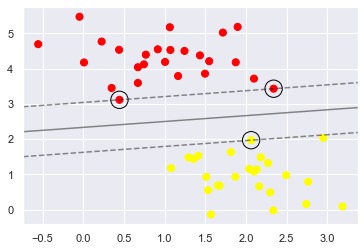

In [43]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model)

In [44]:
# In the figure above we can see the 3 points that consitute the support vectors.
# Only the position of the support vectors matter for the fit. Any points further from the
# margin which are on the correct side do not modify the fit. These points do not contribute
# to the loss function used to fit the model. So, their position and number do not matter,
# as long as they do not cross the margin.

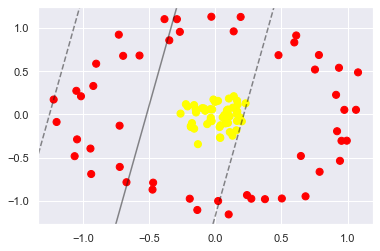

In [47]:
# Now, let's go beyond linear boundaries.

# Let's create a new dataset.
from sklearn.datasets.samples_generator import make_circles

X, y = make_circles(100, factor=.1, noise=.1)

# and fit a linear SVM
clf = SVC(kernel='linear').fit(X, y)

# And plot what happened:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False)

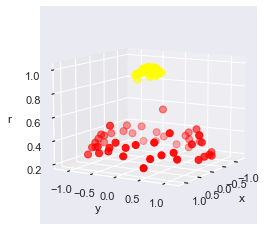

<function __main__.plot_3D(elev=30, azim=30, X=array([[-0.18488023, -0.14490165],
       [-0.0302444 ,  1.12994446],
       [ 0.07646865, -0.10356462],
       [ 0.08450207, -0.02966824],
       [ 0.13948856,  0.21122444],
       [ 0.68240298, -0.94612467],
       [ 1.07957246,  0.48704846],
       [-0.03440132, -0.03697486],
       [ 0.16859583,  0.11386131],
       [-0.19362802, -0.97378345],
       [-0.73051992,  0.92273445],
       [-0.00219841,  0.14550744],
       [ 0.03751234, -0.27074176],
       [-0.13184207, -0.34330377],
       [-0.94493287, -0.39388413],
       [ 0.50320654, -0.97112474],
       [-0.93936814, -0.6882629 ],
       [-0.02767828, -0.07747688],
       [ 0.22901194,  0.12898387],
       [-0.90172918,  0.58696309],
       [ 0.09509578,  0.05765232],
       [-0.26846346,  0.9554718 ],
       [ 0.10088349, -1.15535565],
       [-0.13644525, -1.10402566],
       [ 0.97603268,  0.05343265],
       [-0.01453012,  0.17331663],
       [ 0.05553784, -0.03214822],
       [

In [67]:
# Clearly, no linear discrimination can separate the data.

# But, what if I can transform the space and project the data to a higher dimension?

# One simple projection is to compute a radial basis function centered on the middle:
r = np.exp(-(X**2).sum(1))

# Let's project the data and visualize this extra dimension
from ipywidgets import interact, fixed
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[10, -10], X=fixed(X), y=fixed(y))

In [68]:
# Now the data are crearly separable by a plane around r=0.7 

In [70]:
# Let's fit an SVM with another kernel to find itself the way to separate the data

clf = SVC(kernel='rbf', C=1E16)
clf.fit(X, y)                   # Note: we use the original data (not the projected)


SVC(C=1e+16)

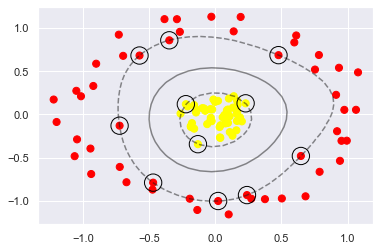

In [75]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)

In [72]:
# We learned a suitable non-linear boundary.